## dataset path

In [1]:
train_dir = 'C:/Users/15972/OneDrive/桌面/FYP/Dataset/Train_data/train_data_after_washing.csv'
test_dir = 'C:/Users/15972/OneDrive/桌面/FYP/Dataset/Test_data/test_data_after_washing.csv'

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn as sns

tf.get_logger().setLevel('ERROR') # return ERROR messages, ignore others

## One-hot

In [3]:
def encode_one_hot(ori_dataframe):
    dummies = pd.get_dummies(ori_dataframe.rating)
    res = pd.concat([ori_dataframe, dummies], axis=1)
    return res

## load data

In [4]:
data = pd.read_csv(train_dir)
data = pd.DataFrame(data)
test_data = pd.read_csv(test_dir)
test_data = pd.DataFrame(test_data)
train_data = pd.DataFrame()
val_data = pd.DataFrame()
data = data[["review","rating"]]
test_data = test_data[["review","rating"]]

In [5]:
data.head()

,review,rating
0,"""Abilify changed my life. There is hope. I was...",10
1,"""I have taken anti-depressants for years, with...",10
2,"""I&#039;ve been on every medicine under the su...",10
3,"""I have insomnia, it&#039;s horrible. My story...",10
4,"""Honestly, I have been taking ativan for 2 yea...",6


## step sampling

In [5]:
for i in range(1,11):
    condition = data['rating'] == i
    subset = data[condition].sample(frac=0.3)
    val_data = pd.concat([subset, val_data])

train_data = data [~data.index.isin(val_data.index)]

In [7]:
val_data

,review,rating
23496,"""I believe I have found the answer I have been...",10
23197,"""At first I read all the reviews positive and ...",10
24361,"""After over a period of 17 years and trying a ...",10
7029,"""Lexapro has changed my life for the better. ...",10
21772,"""This was the only medicine I could take and d...",10
...,...,...
13336,"""It didn&#039;t work for me, I was on 40mg ini...",1
13248,"""I&#039;ve suffered from insomnia for years an...",1
1790,"""I woke up.from the absolute craziest dream I&...",1
13786,"""I did not know what was happening to me when ...",1


In [8]:
train_data

,review,rating
0,"""Abilify changed my life. There is hope. I was...",10
1,"""I have taken anti-depressants for years, with...",10
2,"""I&#039;ve been on every medicine under the su...",10
4,"""Honestly, I have been taking ativan for 2 yea...",6
5,"""1 week on Zoloft for anxiety and mood swings....",8
...,...,...
31413,"""Honestly , This works pretty well for me. It ...",10
31415,"""Had panic attacks and social anxiety starting...",9
31416,"""This is the third med I&#039;ve tried for anx...",2
31417,"""I was super against taking medication. I&#039...",9


In [9]:
train_data['rating'].value_counts()

10    6979
9     4287
8     2968
1     2512
7     1403
5      904
6      874
2      792
3      724
4      550
Name: rating, dtype: int64

## labels distribution

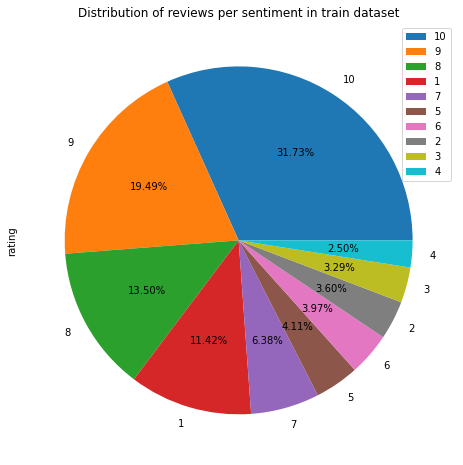

In [10]:
labels = ['10','9','8','1','7','5','6','2','3','4']
train_data['rating'].value_counts().plot.pie(figsize=(8,8),title="Distribution of reviews per sentiment in train dataset",labels=labels,autopct='%.2f%%')
plt.legend(labels)
plt.gca().set_aspect('equal')

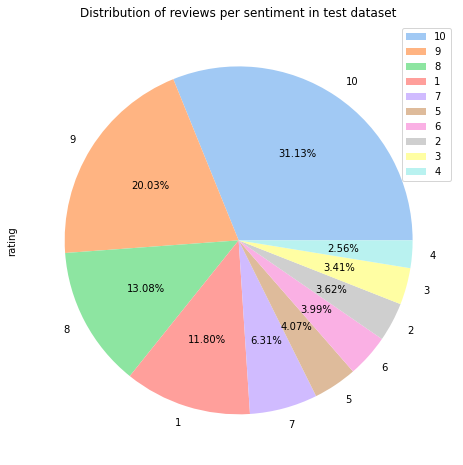

In [11]:
labels = ['10','9','8','1','7','5','6','2','3','4']
colors = sns.color_palette('pastel')[0:10]
test_data['rating'].value_counts().plot.pie(figsize=(8,8),title="Distribution of reviews per sentiment in test dataset",colors=colors,labels=labels,autopct='%.2f%%')
plt.legend(labels)
plt.gca().set_aspect('equal')

## change labels to one-hot

In [6]:
train_data = encode_one_hot(train_data)
val_data = encode_one_hot(val_data)
test_data = encode_one_hot(test_data)
train_target = train_data[[1,2,3,4,5,6,7,8,9,10]]
val_target = val_data[[1,2,3,4,5,6,7,8,9,10]]
test_target = test_data[[1,2,3,4,5,6,7,8,9,10]]

## from datraframes to numpy 

In [7]:
x_train = train_data["review"].to_numpy()
y_train = train_target.to_numpy()
x_val = val_data["review"].to_numpy()
y_val = val_target.to_numpy()
x_test = test_data["review"].to_numpy()
y_test = test_target.to_numpy()

In [14]:
y_train

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [15]:
x_train

array(['"Abilify changed my life. There is hope. I was on Zoloft and Clonidine when I first started Abilify at the age of 15.. Zoloft for depression and Clondine to manage my complete rage. My moods were out of control. I was depressed and hopeless one second and then mean, irrational, and full of rage the next. My Dr. prescribed me 2mg of Abilify and from that point on I feel like I have been cured though I know I&#039;m not.. Bi-polar disorder is a constant battle. I know Abilify works for me because I have tried to get off it and lost complete control over my emotions. Went back on it and I was golden again.  I am on 5mg 2x daily. I am now 21 and better than I have ever been in the past. Only side effect is I like to eat a lot."',
       '"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overn

## load bert preprocess and encoder

In [8]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/albert_en_base/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/albert_en_preprocess/3'

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## define model

In [11]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(10, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [12]:
classifier_model = build_classifier_model()

In [21]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

## define loss and metrics

In [22]:
##loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
##metrics = tf.keras.metrics.CategoricalAccuracy()

In [13]:
def flood_loss(y_true,y_pred):
    alpha = tf.constant([[2],[6],[6],[6],[5],[4],[2],[2],[1],[1]], dtype=tf.float32) #adjust weight for each label
    gamma = 0.25
    epsilon = 1.e-7
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
    ce = -tf.math.log(y_t)
    weight = tf.pow(tf.subtract(1., y_t), gamma)
    fl = tf.matmul(tf.multiply(weight, ce), alpha)
    loss = tf.reduce_mean(fl)
    loss = tf.abs(loss-0.9) + 0.9
    loss = tf.convert_to_tensor(loss)
    return loss
    
#metrics = tf.keras.metrics.Recall()

## define learning rate, optimizer

In [14]:
epochs = 50
steps_per_epoch = 0
for _ in x_train:
    steps_per_epoch = steps_per_epoch + 1
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-6
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [15]:
classifier_model.compile(optimizer=optimizer,
                         loss=flood_loss,
                         metrics=["accuracy", tf.keras.metrics.Recall(name='recall')])

## checkpoint, traing recoords and early stopping

In [16]:
checkpoint_path = 'C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [17]:
csv_callback = tf.keras.callbacks.CSVLogger(
    'C:/Users/15972/OneDrive/桌面/FYP/Model/bert/record.csv', separator=',', append=False
)

In [ ]:
#es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', 
#                                               patience=10)

## model reload

In [29]:
classifier_model.load_weights('C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt_1/cp.ckpt')

## training and evaluate

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=x_train,
                               y=y_train,
                               validation_data=(x_val,y_val),
                               epochs=120,
                               batch_size=8,
                               callbacks=[cp_callback,csv_callback])

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/120
2750/2750 [==============================] - ETA: 0s - loss: 7.2459 - accuracy: 0.1921 - recall: 0.0042
Epoch 1: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt\cp.ckpt
2750/2750 [==============================] - 974s 348ms/step - loss: 7.2459 - accuracy: 0.1921 - recall: 0.0042 - val_loss: 6.2353 - val_accuracy: 0.2947 - val_recall: 0.0016
Epoch 2/120
2750/2750 [==============================] - ETA: 0s - loss: 6.1900 - accuracy: 0.2864 - recall: 0.0094
Epoch 2: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt\cp.ckpt
2750/2750 [==============================] - 1012s 368ms/step - loss: 6.1900 - accuracy: 0.2864 - recall: 0.0094 - val_loss: 5.9681 - val_accuracy: 0.3258 - val_recall: 9.5481e-04
Epoch 3/120
2750/2750 [==============================] - ETA: 0s - loss: 5.8950 - accuracy: 0.3330 - recall: 0.0283
Epoch

Epoch 23/120
2750/2750 [==============================] - ETA: 0s - loss: 2.2460 - accuracy: 0.7457 - recall: 0.6245
Epoch 23: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt\cp.ckpt
2750/2750 [==============================] - 907s 330ms/step - loss: 2.2460 - accuracy: 0.7457 - recall: 0.6245 - val_loss: 5.2652 - val_accuracy: 0.5019 - val_recall: 0.3970
Epoch 24/120
2750/2750 [==============================] - ETA: 0s - loss: 2.0897 - accuracy: 0.7676 - recall: 0.6579
Epoch 24: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt\cp.ckpt
2750/2750 [==============================] - 907s 330ms/step - loss: 2.0897 - accuracy: 0.7676 - recall: 0.6579 - val_loss: 5.3533 - val_accuracy: 0.5066 - val_recall: 0.4126
Epoch 25/120
2750/2750 [==============================] - ETA: 0s - loss: 2.0287 - accuracy: 0.7719 - recall: 0.6617
Epoch 25: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt\cp.ckpt
2750/2750 [==============================] - 906s 329ms/

Epoch 45/120
2750/2750 [==============================] - ETA: 0s - loss: 1.4936 - accuracy: 0.7904 - recall: 0.6771
Epoch 45: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt\cp.ckpt
2750/2750 [==============================] - 897s 326ms/step - loss: 1.4936 - accuracy: 0.7904 - recall: 0.6771 - val_loss: 5.2239 - val_accuracy: 0.5555 - val_recall: 0.4666
Epoch 46/120
2750/2750 [==============================] - ETA: 0s - loss: 1.3941 - accuracy: 0.8039 - recall: 0.6836
Epoch 46: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt\cp.ckpt
2750/2750 [==============================] - 898s 327ms/step - loss: 1.3941 - accuracy: 0.8039 - recall: 0.6836 - val_loss: 5.1721 - val_accuracy: 0.5512 - val_recall: 0.4296
Epoch 47/120
2750/2750 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.8028 - recall: 0.6868
Epoch 47: saving model to C:/Users/15972/OneDrive/桌面/FYP/Model/bert/ckpt\cp.ckpt
2750/2750 [==============================] - 898s 327ms/

## testing 

In [34]:
loss, accuracy = classifier_model.evaluate(x=x_test,y=y_test,batch_size=8)

print(f'Loss: {loss}')
print(f'Record: {accuracy}')

1305/1305 [==============================] - 117s 89ms/step - loss: 3.7212 - recall_1: 0.4693
Loss: 3.721170425415039
Record: 0.4693310260772705


## confusion matrix

In [43]:
y_pred = classifier_model.predict_classes(x_test)
con_mat = confusion_matrix(y_test, y_pred)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')

plt.ylim(0, 10)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

AttributeError: 'Functional' object has no attribute 'predict_classes'

## visualization

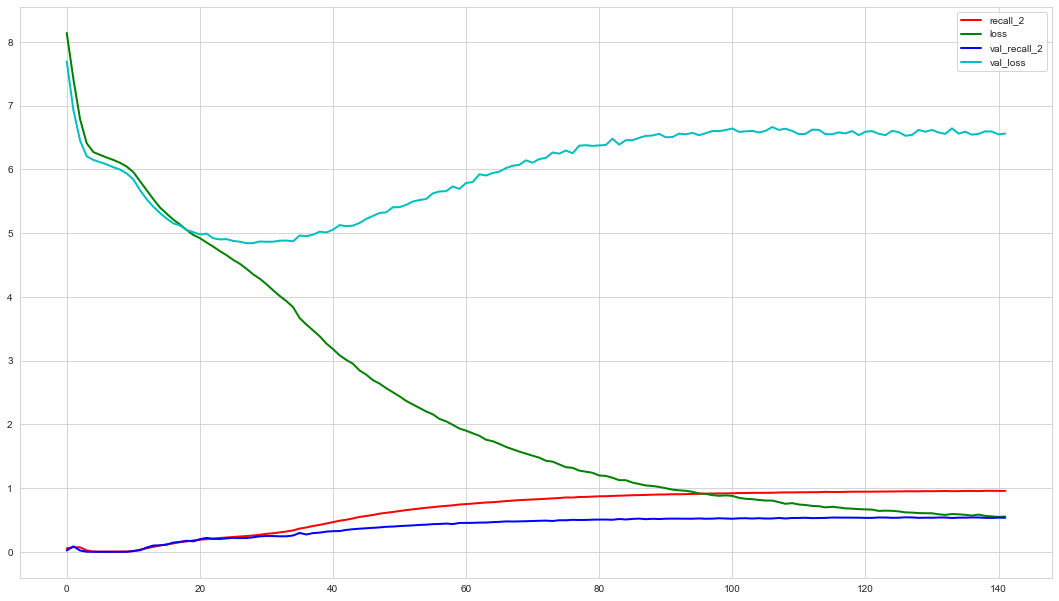

In [45]:
import seaborn as sns
csv_path = 'C:/Users/15972/OneDrive/桌面/FYP/Model/bert/record.csv'
records = pd.read_csv(csv_path)
sns.set_style(style='whitegrid')
labels=['recall_2','loss','val_recall_2','val_loss']
plt.plot(records['epoch'],records['recall_2'], label="recall_2",color='r', linewidth=2)
plt.plot(records['epoch'],records['loss'], label="loss",color='g', linewidth=2)
plt.plot(records['epoch'],records['val_recall_2'], label="val_recall_2",color='b', linewidth=2)
plt.plot(records['epoch'],records['val_loss'], label="val_loss",color='c', linewidth=2)
plt.legend(labels)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
csv_path = 'C:/Users/15972/OneDrive/桌面/FYP/Model/record_stepSampling_lowLR.csv'
records = pd.read_csv(csv_path)
sns.set_style(style='whitegrid')
labels=['categorical_accuracy','loss','val_categorical_accuracy','val_loss']
plt.plot(records['epoch'],records['categorical_accuracy'], label="categorical_accuracy",color='r', linewidth=2)
plt.plot(records['epoch'],records['loss'], label="loss",color='g', linewidth=2)
plt.plot(records['epoch'],records['val_categorical_accuracy'], label="val_categorical_accuracy",color='b', linewidth=2)
plt.plot(records['epoch'],records['val_loss'], label="val_loss",color='c', linewidth=2)
plt.legend(labels)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)